## What is Classification? (with mtcars)


## Setup and Imports

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')
require('DescTools')
require('ggrepel')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse
Loading required package: DescTools
Loading required package: ggrepel


## Load the data

read mtcars

In [4]:
%%R -o mtcars

# create a column called name and set it to the rownames of mtcars
mtcars$name <- rownames(mtcars)

# delete the rownames
rownames(mtcars) <- NULL

mtcars


    mpg cyl  disp  hp drat    wt  qsec vs am gear carb                name
1  21.0   6 160.0 110 3.90 2.620 16.46  0  1    4    4           Mazda RX4
2  21.0   6 160.0 110 3.90 2.875 17.02  0  1    4    4       Mazda RX4 Wag
3  22.8   4 108.0  93 3.85 2.320 18.61  1  1    4    1          Datsun 710
4  21.4   6 258.0 110 3.08 3.215 19.44  1  0    3    1      Hornet 4 Drive
5  18.7   8 360.0 175 3.15 3.440 17.02  0  0    3    2   Hornet Sportabout
6  18.1   6 225.0 105 2.76 3.460 20.22  1  0    3    1             Valiant
7  14.3   8 360.0 245 3.21 3.570 15.84  0  0    3    4          Duster 360
8  24.4   4 146.7  62 3.69 3.190 20.00  1  0    4    2           Merc 240D
9  22.8   4 140.8  95 3.92 3.150 22.90  1  0    4    2            Merc 230
10 19.2   6 167.6 123 3.92 3.440 18.30  1  0    4    4            Merc 280
11 17.8   6 167.6 123 3.92 3.440 18.90  1  0    4    4           Merc 280C
12 16.4   8 275.8 180 3.07 4.070 17.40  0  0    3    3          Merc 450SE
13 17.3   8 275.8 180 3.0

## Logistic Regression 

What is the probability that a car is automatic or manual given it's weight and horsepower? 

In other words: `am ~ wt + hp`

In [5]:
%%R 

# Run logistic regression
logistic <- glm(am ~ wt + hp, data = mtcars, family = binomial(link = 'logit'))

# see the output
print(summary(logistic))


Call:
glm(formula = am ~ wt + hp, family = binomial(link = "logit"), 
    data = mtcars)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) 18.86630    7.44356   2.535  0.01126 * 
wt          -8.08348    3.06868  -2.634  0.00843 **
hp           0.03626    0.01773   2.044  0.04091 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43.230  on 31  degrees of freedom
Residual deviance: 10.059  on 29  degrees of freedom
AIC: 16.059

Number of Fisher Scoring iterations: 8



In [6]:
%%R 
# see the coefficients
# in machine learning land we don't care too much about these...
print(exp(coef(logistic)))


 (Intercept)           wt           hp 
1.561455e+08 3.085967e-04 1.036921e+00 


In [7]:
%%R 

# look at pseudo R2
# but we do care about this
print(PseudoR2(logistic, which = 'McFadden'))


 McFadden 
0.7673104 


Oh look, a pseudo r^2 of .76. That's pretty good.

But now, what if our goal was prediction, not inference. Suppose I don't care much about how these things are related to one another. I just want to build a machine that categorizes cars as automatic or manual.

Visually, this is what we're doing

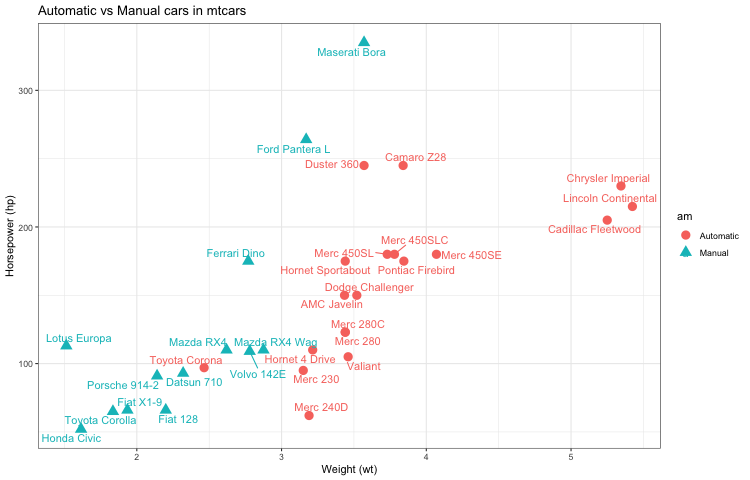

In [8]:
%%R -w 750 
mtcars$am <- factor(mtcars$am, labels = c('Automatic', 'Manual'))

ggplot(mtcars) +
    aes(x=wt, y=hp, color=am, shape=am, label=name) +
    geom_point(size=4) + 
    geom_text_repel() +
    theme_bw() + 
    labs(
        title="Automatic vs Manual cars in mtcars",
        y = "Horsepower (hp)", x= "Weight (wt)")

What is a classification task? The idea is to train an algorithm that will a boundary between the two categories and categorize any new data that comes in accurately. 

![](flashcards/Classification_web.png)

## The logistic regression is a classifier!!!

or...well...it can become one

In [9]:
%%R 

df <- mtcars %>% mutate(
    prediction_odds = exp(predict(logistic)),
    prediction_pct = prediction_odds / (1 + prediction_odds),
    prediction = ifelse(prediction_pct > 0.5, 'Manual', 'Automatic')
)

df %>% head()

   mpg cyl disp  hp drat    wt  qsec vs        am gear carb              name
1 21.0   6  160 110 3.90 2.620 16.46  0    Manual    4    4         Mazda RX4
2 21.0   6  160 110 3.90 2.875 17.02  0    Manual    4    4     Mazda RX4 Wag
3 22.8   4  108  93 3.85 2.320 18.61  1    Manual    4    1        Datsun 710
4 21.4   6  258 110 3.08 3.215 19.44  1 Automatic    3    1    Hornet 4 Drive
5 18.7   8  360 175 3.15 3.440 17.02  0 Automatic    3    2 Hornet Sportabout
6 18.1   6  225 105 2.76 3.460 20.22  1 Automatic    3    1           Valiant
  prediction_odds prediction_pct prediction
1     5.342583344    0.842335537     Manual
2     0.680058222    0.404782533  Automatic
3    32.603078929    0.970240822     Manual
4     0.043545086    0.041728035  Automatic
5     0.074561828    0.069388122  Automatic
6     0.005013165    0.004988159  Automatic


In [10]:
%%R -o df

df %>% select(wt, hp, prediction, am) %>% head()

     wt  hp prediction        am
1 2.620 110     Manual    Manual
2 2.875 110  Automatic    Manual
3 2.320  93     Manual    Manual
4 3.215 110  Automatic Automatic
5 3.440 175  Automatic Automatic
6 3.460 105  Automatic Automatic


## How well did our classifier do?

In [11]:
pd.crosstab(df.prediction, df.am)

am,Automatic,Manual
prediction,,
Automatic,18,1
Manual,1,12


A simple accuracy score

In [12]:
correct = 18 + 12 
incorrect = 1 + 1

accuracy = correct / (correct + incorrect)
accuracy * 100

93.75

![](flashcards/Accuracy_web.png)